# Data Story
Let's take a dive into the data to discover interesting trends that might guide future feature engineering efforts. First off, what are the demographics of the riders using the Citibike program?

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Wrangling in one Step
# Specify columns to use
columns = ['bikeid', 'birth year', 'end station id', 
           'end station latitude', 'end station longitude', 'end station name',
           'gender', 'start station id', 'start station latitude', 'start station longitude',
           'start station name', 'starttime', 'stoptime', 'tripduration', 'usertype']

# use your path
path = r'/Users/vincent_zaballa/Springboard_Assignments/capstone_proj_2/CITI_BIKE/2016_data' 
all_files = glob.glob(os.path.join(path, "*.csv"))

# Appending all imported dataframes to empty df
frame = pd.DataFrame()
list_ = []
for file_ in all_files:
    df = pd.read_csv(file_, index_col=None, header=0)
    list_.append(df)
bike_df = pd.concat(list_)

# Naming columns for future use
bike_df.columns = columns + bike_df.columns[15:].tolist()

# Creating left and right dfs
right_df = bike_df[bike_df.iloc[:,0].notnull() == False]
left_df = bike_df[bike_df.iloc[:,0].notnull() == True]
right_df = right_df.dropna(axis=1, how='all')
left_df = left_df.dropna(axis=1, how='all')

# Convert individual dfs' timestamps
# Need to convert two different format dfs to timestamp beforehand to speed things up MASSIVELY
right_df.starttime = pd.to_datetime(right_df.starttime, format='%m/%d/%Y %H:%M:%S')
right_df.stoptime = pd.to_datetime(right_df.stoptime, format='%m/%d/%Y %H:%M:%S')
left_df.starttime = pd.to_datetime(left_df.starttime, format='%Y-%m-%d %H:%M:%S')
left_df.stoptime = pd.to_datetime(left_df.stoptime, format='%Y-%m-%d %H:%M:%S')

# Combining
frames = [right_df, left_df]
bike_df = pd.concat(frames, axis=0)

In [4]:
# Removing values before 2016 (start of this dataset) -- No longer needed. Why was it necessary in the first place?
#bike_df = bike_df[bike_df.starttime > '2016-01-01']

# Setting starttime as the index
bike_df.index = bike_df['starttime']
bike_df = bike_df.sort_index()

# Fixing Null Values
# Setting NaN values equal to average age
bike_df[bike_df['birth year'].notnull() == False] = np.ceil(bike_df['birth year'].mean()).astype(int)

# Converting the whole column to int to save space
bike_df.loc[:,'birth year'] = bike_df['birth year'].copy().astype(int)
bike_df.loc[:,'tripduration'] = bike_df['tripduration'].copy().astype(int)
bike_df.loc[:,'end station id'] = bike_df['end station id'].copy().astype(int)
bike_df.loc[:,'start station id'] = bike_df['start station id'].copy().astype(int)
bike_df.loc[:,'gender'] = bike_df['gender'].copy().astype(int)
bike_df.loc[:,'bikeid'] = bike_df['bikeid'].copy().astype(int)

# Create a one-time user gender class (unknown) instead of "Other" class
bike_df.loc[:,'gender'].loc[bike_df['usertype'] == 'Customer'] = 3

# Fixing a station's lat/lon
bike_df.loc[:, 'end station latitude'][bike_df['end station name'] == 'NYCBS Depot BAL - DYR'] = 40.75903008
bike_df.loc[:, 'end station longitude'][bike_df['end station name'] == 'NYCBS Depot BAL - DYR'] = -73.9938587

# Deleting anomalous (no data) station
bike_df = bike_df[bike_df['end station name'] != 'SSP - Basement']

# Removing the missing start station lat/lons
bike_df = bike_df[bike_df['start station longitude'] != 0]

# Creating distance travelled
# Distance travelled - vectorized
bike_df['LAT_start_rad'], bike_df['LON_start_rad'] = np.radians(bike_df['start station latitude']), np.radians(bike_df['start station longitude'])
bike_df['LAT_end_rad'], bike_df['LON_end_rad'] = np.radians(bike_df['end station latitude']), np.radians(bike_df['end station longitude'])
bike_df['dLON'] = bike_df['LON_end_rad'] - bike_df['LON_start_rad']
bike_df['dLAT'] = bike_df['LAT_end_rad'] - bike_df['LAT_start_rad']
bike_df['distance_miles'] = 3961 * 2 * np.arcsin(np.sqrt(
    np.sin(bike_df['dLAT']/2)**2 + np.cos(bike_df['LAT_start_rad']) * np.cos(bike_df['LAT_end_rad']) * np.sin(bike_df['dLON']/2)**2
))
del bike_df['LON_start_rad'], bike_df['LAT_start_rad'], bike_df['LAT_end_rad'], bike_df['LON_end_rad'], bike_df['dLON'], bike_df['dLAT']


# Average velocity - Assuming they went in a straight line and were moving the entire time...
bike_df['speed_miles/hour'] = bike_df['distance_miles'] / (bike_df['tripduration']/3600)

# deleting max speed data error (trip duration way too long)
bike_df = bike_df.loc[bike_df['speed_miles/hour'] != bike_df['speed_miles/hour'].max()]

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
from scipy.stats import iqr
age_range = (np.max(bike_df['birth year']) - np.min(bike_df['birth year'][bike_df['birth year'] > 1920]))
age_IQR = iqr(bike_df['birth year']).astype(int)
age_h = 2*age_IQR*(len(bike_df['birth year']))**(-1/3)
iqr(bike_df['birth year']).astype(int)

15

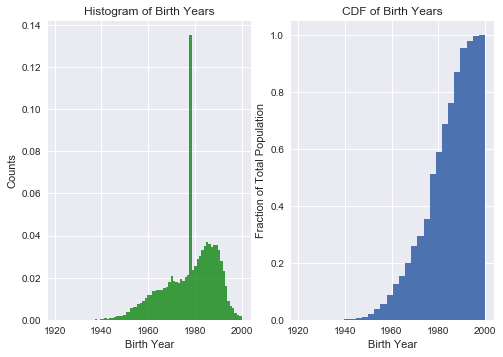

In [6]:
# histogram of birth year
ax1 = plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(bike_df['birth year'][bike_df['birth year'] > 1920],
                            bins = 78,    # Tried using Freedman-Diaconis Rule... IQR is too small.
                            normed=1, facecolor='green', alpha=0.75)
plt.xlabel('Birth Year')
plt.ylabel('Counts')
plt.title('Histogram of Birth Years')
plt.grid(True)

# Plot the CDF
ax2 = plt.subplot(1, 2, 2)
plt.hist(bike_df['birth year'][bike_df['birth year'] > 1920],
         bins=30, cumulative=True, normed=True)
plt.xlabel('Birth Year')
plt.ylabel('Fraction of Total Population')
plt.title('CDF of Birth Years')
plt.grid(True)

plt.show()

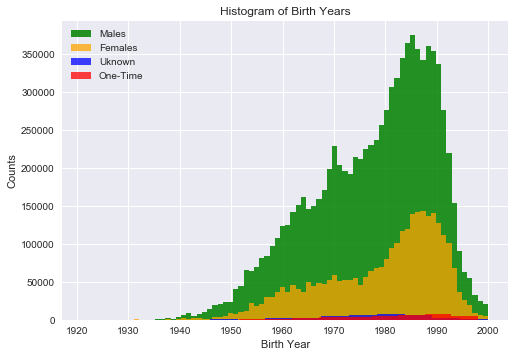

In [7]:
# Histogram by gender goes here.
plt.hist(bike_df['birth year'][(bike_df['birth year'] > 1920) & (bike_df['gender'] == 1)], 
         bins = 78,
         facecolor='green', alpha=0.85,
         label='Males')
plt.hist(bike_df['birth year'][(bike_df['birth year'] > 1920) & (bike_df['gender'] == 2)], 
         bins = 78, facecolor='orange', alpha=0.75,
         label='Females')
plt.hist(bike_df['birth year'][(bike_df['birth year'] > 1920) & (bike_df['gender'] == 0)], 
         bins = 12, facecolor='blue', alpha=0.75,
         label='Uknown')
plt.hist(bike_df['birth year'][(bike_df['birth year'] > 1920) & (bike_df['gender'] == 3)], 
         bins = 12, facecolor='red', alpha=0.75,
         label='One-Time')
plt.xlabel('Birth Year')
plt.ylabel('Counts')
plt.title('Histogram of Birth Years')
plt.legend()
plt.grid(True)

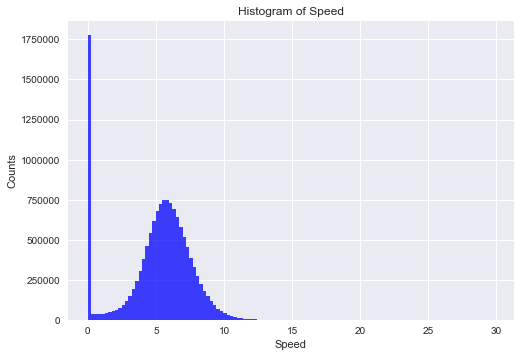

In [8]:
# Histogram of speeds
plt.hist(bike_df['speed_miles/hour'][bike_df['speed_miles/hour'] < 30], 
         bins = 120, facecolor='blue', alpha=0.75)
plt.xlabel('Speed')
plt.ylabel('Counts')
plt.title('Histogram of Speed')
plt.grid(True)

In [9]:
# More interesting question: when in the day do the roundtrip trips occur?

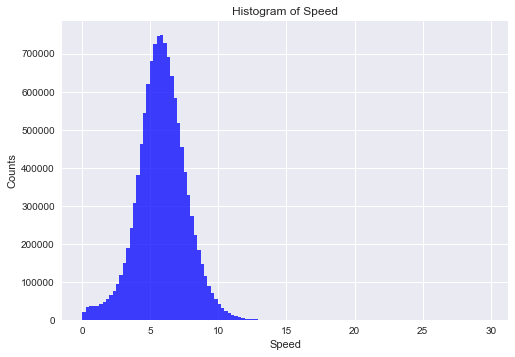

In [10]:
# Histogram of speeds, without zero
plt.hist(bike_df['speed_miles/hour'][(bike_df['speed_miles/hour'] < 30) & (bike_df['speed_miles/hour'] > 0)], 
         bins = 120, facecolor='blue', alpha=0.75)
plt.xlabel('Speed')
plt.ylabel('Counts')
plt.title('Histogram of Speed')
plt.grid(True)


## Data Story: More Questions
To continue assessing the data, I will look at the following factors to see if there is an interesting trend:
1. Speed by gender and age
2. Average length of the trip by gender and age
3. Demand per day of the week
4. Demand per hour of the day

I'll go through and assess these questions in a graphical format. They will help provide intuition and insight into the time series forecasting process, especially when deciding how to forecast demand. For example, we will see if the demand for bikes is different between weekdays and weekends, and how those trends differ. We can even look at the difference in hour of the day to improve the time series forecasting model accuracy. Remember, I said that the trend is an important variable for time series analysis, and the more constant the trend, the easier it is to model future events.

In [11]:
# Average speed by each gender and age group
bike_df['age'] = 2017 - bike_df.loc[:,'birth year']

In [12]:
def gend_age_speed(df):
    ''' 
    Accepts the pivot tables only. Specifically the pivot tables that I just made in the previous cell.
    '''
    avg_speeds = []
    for i in range(len(df)):
        avg_speeds.append(np.sum(
            df.drop('total', axis=1).iloc[i] * df.drop('total', axis=1).iloc[i].index
        )/df.total.iloc[i])
    new_col = pd.Series(avg_speeds)
    df['avg_speed'] = new_col.values
    return df

In [13]:
# speed by gender and age -> Age on x-axis, gender two different curves(4), and mph to the left
# Average speed by each age group and then plot line graph
speed_condensed_df = bike_df[(bike_df['speed_miles/hour'] < 30) & (bike_df['speed_miles/hour'] > 0)]

male_speed_condensed_df = speed_condensed_df[speed_condensed_df['gender'] == 1]
female_speed_condensed_df = speed_condensed_df[speed_condensed_df['gender'] == 2]
other_speed_condensed_df = speed_condensed_df[speed_condensed_df['gender'] == 0]

male_age_speed_df = male_speed_condensed_df.groupby(['age','speed_miles/hour']).size()
female_age_speed_df = female_speed_condensed_df.groupby(['age','speed_miles/hour']).size()
other_age_speed_df = other_speed_condensed_df.groupby(['age','speed_miles/hour']).size()

# Fix groupby
male_age_speed_df = male_age_speed_df.reset_index('speed_miles/hour')
female_age_speed_df = female_age_speed_df.reset_index('speed_miles/hour')
other_age_speed_df = other_age_speed_df.reset_index('speed_miles/hour')

# Round up the speed to make pivot table computation easier
male_age_speed_df['speed_miles/hour'] = np.ceil(male_age_speed_df['speed_miles/hour'])
female_age_speed_df['speed_miles/hour'] = np.ceil(female_age_speed_df['speed_miles/hour'])
other_age_speed_df['speed_miles/hour'] = np.ceil(other_age_speed_df['speed_miles/hour'])

# Create pivot tables
male_age_speed_pivot = male_age_speed_df.pivot_table(values=0, index='age', columns='speed_miles/hour', aggfunc='count')
female_age_speed_pivot = female_age_speed_df.pivot_table(values=0, index='age', columns='speed_miles/hour', aggfunc='count')
other_age_speed_pivot = other_age_speed_df.pivot_table(values=0, index='age', columns='speed_miles/hour', aggfunc='count')

# Convert nans to zero
male_age_speed_pivot = male_age_speed_pivot.fillna(value=0)
female_age_speed_pivot = female_age_speed_pivot.fillna(value=0)
other_age_speed_pivot = other_age_speed_pivot.fillna(value=0)

# Create a summation column
male_age_speed_pivot['total'] = male_age_speed_pivot.sum(axis=1)
female_age_speed_pivot['total'] = female_age_speed_pivot.sum(axis=1)
other_age_speed_pivot['total'] = other_age_speed_pivot.sum(axis=1)

# Creating average speed column from average speed function
gend_age_speed(male_age_speed_pivot)
gend_age_speed(female_age_speed_pivot)
gend_age_speed(other_age_speed_pivot)

# Limit age to 65 years of age
male_age_speed_pivot = male_age_speed_pivot.loc[17:65]
female_age_speed_pivot = female_age_speed_pivot.loc[17:65]
other_age_speed_pivot = other_age_speed_pivot.loc[17:65]

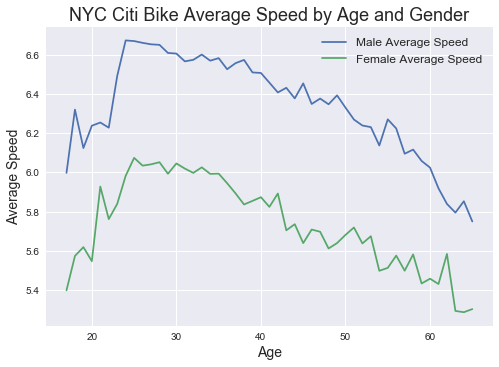

In [14]:
# We have all the data. Time to plot.
x_vals = male_age_speed_pivot.index
plt.plot(x_vals, male_age_speed_pivot.avg_speed, label='Male Average Speed')
plt.plot(x_vals, female_age_speed_pivot.avg_speed, label='Female Average Speed')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Average Speed', fontsize=14)
plt.title('NYC Citi Bike Average Speed by Age and Gender', fontsize=18)
plt.show()

In [15]:
def gend_age_trip(df):
    ''' 
    Accepts the pivot tables only. Specifically the pivot tables that I just made in the previous cell.
    '''
    avg_trips = []
    for i in range(len(df)):
        avg_trips.append(np.sum(
            df.drop('total', axis=1).iloc[i] * df.drop('total', axis=1).iloc[i].index
        )/df.total.iloc[i])
    new_col = pd.Series(avg_trips)
    df['avg_trip'] = new_col.values
    return df

In [16]:
# Average length of trip by age
# Remove all values greater than 8 hours (28,800 seconds) and less than 1 second
trip_condensed_df = bike_df[(bike_df['tripduration'] < 28800) & (bike_df['tripduration'] > 1)]

# Divide by gender
male_duration_condensed_df = trip_condensed_df[trip_condensed_df['gender'] == 1]
female_duration_condensed_df = trip_condensed_df[trip_condensed_df['gender'] == 2]
other_duration_condensed_df = trip_condensed_df[trip_condensed_df['gender'] == 0]

male_age_trip_df = male_duration_condensed_df.groupby(['age','tripduration']).size()
female_age_trip_df = female_duration_condensed_df.groupby(['age','tripduration']).size()
other_age_trip_df = other_duration_condensed_df.groupby(['age','tripduration']).size()

# Fix groupby
male_age_trip_df = male_age_trip_df.reset_index('tripduration')
female_age_trip_df = female_age_trip_df.reset_index('tripduration')
other_age_trip_df = other_age_trip_df.reset_index('tripduration')

# Create pivot tables
male_age_trip_pivot = male_age_trip_df.pivot_table(values=0, index='age', 
                             columns='tripduration', aggfunc='count').fillna(value=0).astype(int)
female_age_trip_pivot = female_age_trip_df.pivot_table(values=0, index='age', 
                             columns='tripduration', aggfunc='count').fillna(value=0).astype(int)
other_age_trip_pivot = other_age_trip_df.pivot_table(values=0, index='age', 
                             columns='tripduration', aggfunc='count').fillna(value=0).astype(int)

# Create a summation column
male_age_trip_pivot['total'] = male_age_trip_pivot.sum(axis=1)
female_age_trip_pivot['total'] = female_age_trip_pivot.sum(axis=1)
other_age_trip_pivot['total'] = other_age_trip_pivot.sum(axis=1)

# Creating average speed column from average speed function
gend_age_trip(male_age_trip_pivot)
gend_age_trip(female_age_trip_pivot)
gend_age_trip(other_age_trip_pivot)

# Limit age to 65 years of age
male_age_trip_pivot = male_age_trip_pivot.loc[17:65]
female_age_trip_pivot = female_age_trip_pivot.loc[17:65]
other_age_trip_pivot = other_age_trip_pivot.loc[17:65]

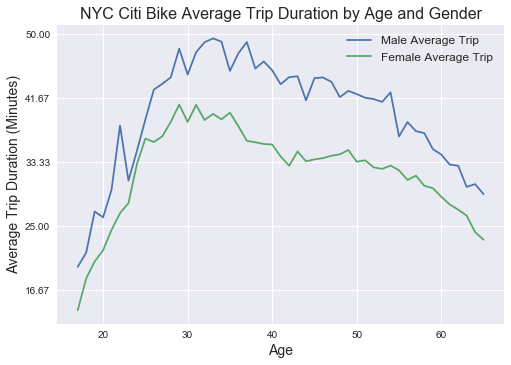

In [17]:
# We have all the data. Time to plot.
import matplotlib as mpl

fig, ax = plt.subplots()
x_vals = male_age_trip_pivot.index

def mjrFormatter(x, pos):
    return "%.2f" % (x/60)

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))

plt.plot(x_vals, male_age_trip_pivot.avg_trip, label='Male Average Trip')
plt.plot(x_vals, female_age_trip_pivot.avg_trip, label='Female Average Trip')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Average Trip Duration (Minutes)', fontsize=14)
plt.title('NYC Citi Bike Average Trip Duration by Age and Gender', fontsize=16)
plt.show()

## Time-Series Data Story
Alright, since the hard work was put into cleaning and converting this dataset's time information to panda's datetime format, let's have a look at some of the statistics of ridership during the year. To do this, I can resample the original dataframe into counts of trips by day and month, and look at interesting trends with these resampled dataframes.

I will start by assessing the number of trips per day in 2016 and then move on to the demand for bikes by month. Finally, I will look at the average demand for bikes by hour of the day for each day of the week and demand for bikes by hour of the day. In summary:
- Number of trips per day in 2016.
- Demand for bikes by month.
- Average demand for bikes by hour and day of the week.
- Demand for bikes by hour of the day.

In [18]:
# Simplify by making a univariate, total bike counts, dataframe
total_DayCounts_df = bike_df.resample('D').apply({'bikeid':'count'})
print('Number of Days (leap year!): ',len(total_DayCounts_df))
total_DayCounts_df.columns = ['ride_count']

Number of Days (leap year!):  366


In [19]:
total_HourCounts_df = bike_df.resample('H').apply({'bikeid':'count'})
print('Total Hours Bikes were Operational:',len(total_HourCounts_df))
total_HourCounts_df.columns = ['ride_count']

Total Hours Bikes were Operational: 8784


In [2]:
# Total number of rides per day
total_DayCounts_df.rename(columns={'ride_count': 'Daily Number of Trips'}).plot()
# Create the rolling class
r = total_DayCounts_df.rolling(window = 28)
r.mean()['ride_count'].plot(color='red', label='Rolling Window: 28 Days')
plt.legend(loc='best', fontsize=12)
#plt.xlim(['2016-01-01 00:00:41', '2016-12-31 23:59:56'])
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day in 2016', fontsize=18)

NameError: name 'total_DayCounts_df' is not defined

In [3]:
r.mean()['ride_count'].index

NameError: name 'r' is not defined

We were able to get the number of trips per day  in the citibike system by resampling the original dataframe and aggregating by the number of counts. Next, I want to plt the monthly number of rides. I can do this in two ways. One, the same as before, which is just resampling the entire dataset and counting the number of trips in a month, or using the previous, day-sampled, dataset and using a rolling window of 28 days to collect the average number of rides per month. While the resampling by month is the more straightforward option, I want to do this in order to show a difference between resampling and using a rolling window with the 

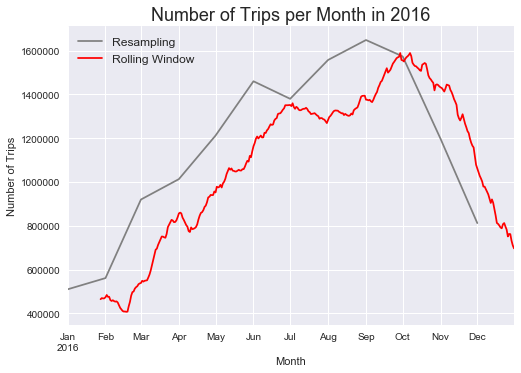

In [21]:
# plot of resampled versus rolling window of 28 days.
# regular resampling method
bike_df.resample('M').apply({'bikeid':'count'}).rename(columns={'bikeid': 'Resampling'}).plot(color='gray')
# Created a rolling class. Window uses 28 data points. Using total count now.
r.sum()['ride_count'].plot(color='red', label='Rolling Window')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Month in 2016', fontsize=18)

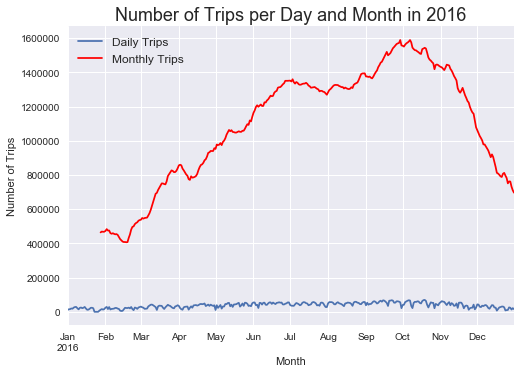

In [22]:
#Superimpose the monthly rolling window on the daily window
total_DayCounts_df.rename(columns={'ride_count': 'Daily Trips'}).plot()
r.sum()['ride_count'].plot(color='red', label='Monthly Trips')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day and Month in 2016', fontsize=18)

## Comparison of Resampling and Rolling Windows

The rolling window function returns a much nicer, and smooth, function that I can use to assess the time series traits of this dataset. The resampling method of plotting the monthly was much more discrete, as should be expected, but it had a similar overall trend.

Just for fun, I wanted to compare the rolling monthly window to the daily total counts time series. This really demonstrates the effect of choosing what type of time period to choose for your time series analysis. The monthly aggregate contains the overall trend seen in the daily ride count time series from earlier, gradually increasing from January until peaking in October, and then steeply falling back off in November and December. 

After the fact, it makes sense, but I was able to use one rolling class function to relate the total number of rides per day and per month by applying a different summary statistic. For the rides per day, the mean of the rolling window helped to find a smooth trend of the daily number of bike rides, while the count function was able to relate the monthly number of rides. The last plot shows the large difference in this choice, relating the count of the rolling window to the total number of rides per day.

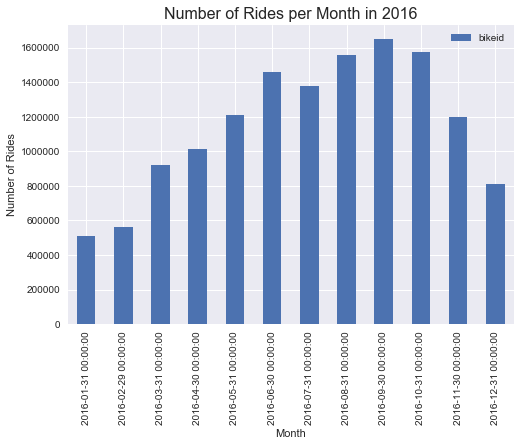

In [23]:
# Total number of rides per month
bike_df.resample('M').apply({'bikeid':'count'}).plot(kind='bar')
plt.ylabel('Number of Rides')
plt.xlabel('Month')
plt.title('Number of Rides per Month in 2016', fontsize=16)
# I need to add ticks to y-axis later for readability

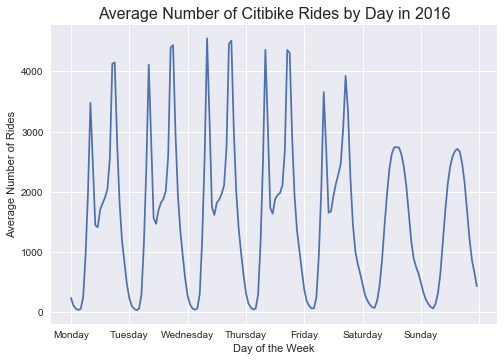

In [24]:
# By day of the week
total_HourCounts_df['week'] = total_HourCounts_df.index.week
total_HourCounts_df['week_beginning'] = total_HourCounts_df.index.to_period('W').to_timestamp()
total_HourCounts_df['week_time'] = total_HourCounts_df.index.to_series() - total_HourCounts_df['week_beginning']

# Create a pivot table that has the weeks in columns and hour of each day of the week in rows
HrCount_pivot = total_HourCounts_df.pivot_table(values='ride_count', index='week_time', columns='week')
 
# Mean number of bike rides per hour of the day, by day of the week
# Add some titles and axis labels!
fig, ax = plt.subplots()
ax.plot_date(HrCount_pivot.index, HrCount_pivot.mean(axis=1), marker='', linestyle='-')

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.ylabel('Average Number of Rides')
plt.xlabel('Day of the Week')
plt.title('Average Number of Citibike Rides by Day in 2016', fontsize=16)
 
ax.set_xticklabels(labels)
plt.show()

The difference in trend between the weekday and the weekend is interesting in that the problem of predicting the number of bikes at each station will probably be different on the weekend than on the weekday. As well, the stations that are popular during the week may not be as popular on the weekend.

In fact, I will separate the weekday from the weekend, because the seasonality, trend, and average level of activity are much different on the weekdays than on the weekend.

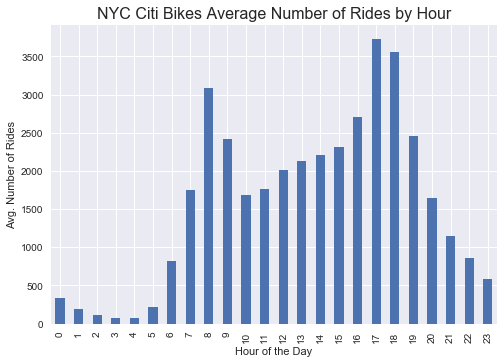

In [25]:
# By hour of the day
total_HourCounts_df.ride_count.groupby(total_HourCounts_df.index.hour).mean().plot(kind='bar')
plt.ylabel('Avg. Number of Rides')
plt.xlabel('Hour of the Day')
plt.title('NYC Citi Bikes Average Number of Rides by Hour', fontsize=16)

## Plotting Overall Time Series
Great, we have a general idea of when, during the day, the week, and over the year, when Citibikes are most used. This helps to give an overall idea of when the bikes are in highest demand and gives some direction about the seasonality and trends for demand of bikes over the year. This will help us create a forecast of demand to improve the Citibike scheme. 

~~One problem that Citibike has is with the amount of bikes at each station. For example, some stations do not have enough bikes during the day and others are over-crowded, not allowing customers to park their bikes at the location which they would like to end their journey. Both congestion and scarcity should be avoided if possible. In order to avoid these two scenarios, it would be most helpful to predict the number of bikes that will be present at the station in the next few hours, days, weeks, and months.~~

We can use some of the insights from before to steer our thinking, but it is most likely that each of these graphs will vary by each station. It would be impossible to manually run through these charts and try to predict which station will run out of bikes or will be full of bikes, soon.

## Segmentation by Station
To get an idea of these trends, I'll isolate the top-3, bottom-3, and random-3 stations with the highest rate of daily bicycles leaving and plot their time series trends. From there, I'll construct a time series forecast for each station using half of the year's data.

It's important to note that this is only half of the problem. This will be looking at the rate of bicycles leaving a station and not at the rate of bicycles arriving, for now.

In [26]:
# Sort the mean number of bikes leaving per day by station
bike_df['date'] = bike_df.index.date
start_station_df = bike_df.groupby(['date', 'start station id']).size()
start_station_df = start_station_df.reset_index('start station id')
start_station_df = start_station_df.rename(columns={0: "rides_leaving"})
start_station_df.head()

,start station id,rides_leaving
date,,
2016-01-01,72,19
2016-01-01,79,15
2016-01-01,82,10
2016-01-01,83,14
2016-01-01,116,39


In [27]:
start_station_pivot = start_station_df.pivot_table(values='rides_leaving', index='date', columns='start station id')
start_station_pivot = start_station_pivot.fillna(value=0).astype(int)
# Mean number of rides leaving throughout the year
start_station_vector = start_station_pivot.mean(axis=0).sort_values(ascending=False)
print(start_station_vector.head(3))
print('')
print(start_station_vector.tail(3))

start station id
1978    4383.599448
519      392.577348
435      266.842541
dtype: float64

start station id
3014    0.008287
294     0.005525
3385    0.002762
dtype: float64


58.8425414364641
3137


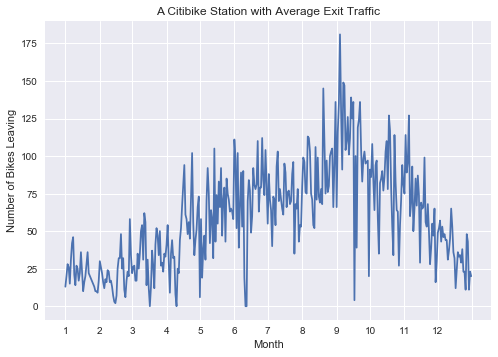

In [28]:
from matplotlib.dates import MonthLocator
# Average station
print(start_station_vector.mean())
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
print(find_nearest(start_station_vector, start_station_vector.mean()))  # This is station number

fig, ax = plt.subplots()

ax.plot_date(start_station_pivot.index,
             start_station_pivot[find_nearest(start_station_vector, start_station_vector.mean())],
             marker='', linestyle='-')

labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
mloc = MonthLocator()
ax.xaxis.set_major_locator(mloc)
ax.set_xticklabels(labels)

#plt.setp(xticklabels=labels)
plt.ylabel('Number of Bikes Leaving')
plt.xlabel('Month')
plt.title('A Citibike Station with Average Exit Traffic', fontsize=16)

In [29]:
# Plot time series for top, bottom, and random (3x3 big chart)
short_df = start_station_pivot[[519, 435, 402, 3014, 294, 3385, 3424, 363, 3355]]

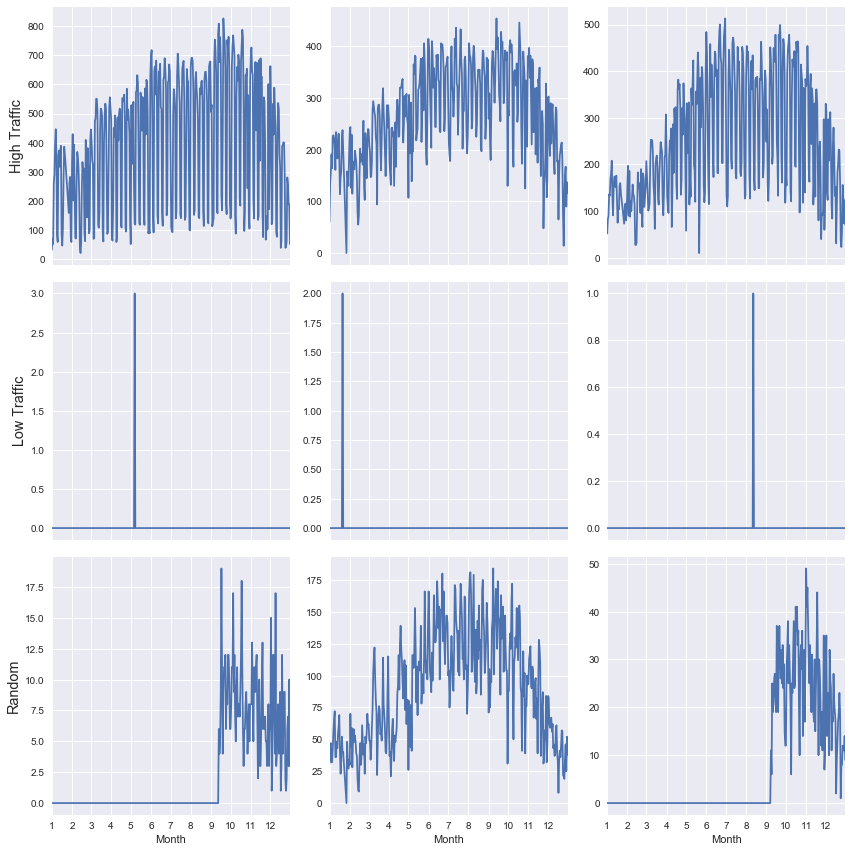

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharex=True)

rows = ['High Traffic', 'Low Traffic', 'Random']

labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

plt.setp(axes, xticklabels=labels)

short_df[519].plot(ax=axes[0,0])
short_df[435].plot(ax=axes[0,1])
short_df[402].plot(ax=axes[0,2])
short_df[3014].plot(ax=axes[1,0])
short_df[294].plot(ax=axes[1,1])
short_df[3385].plot(ax=axes[1,2])
short_df[3424].plot(ax=axes[2,0])
short_df[363].plot(ax=axes[2,1])
short_df[3355].plot(ax=axes[2,2])

for i, row in enumerate(axes):
    for j, cell in enumerate(row):
        if i == len(axes) - 1:
            cell.set_xlabel("Month")

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')
    
#fig.suptitle("Title centered above all subplots", fontsize=16)
fig.tight_layout()


After plotting three of the top, bottom, and randomly selected traffic leaving a station, we can see that the top three have similar traffic trends, but possibly not the same for analyzing the time series of each. That said, I will have to create a pipeline that finds the trends for each individual station and then forecast the number of bikes that will be leaving that station in the next month or week.

The low traffic stations have a peak of one or two bikes leaving the station in a year. It doesn't make sense why this station should even be in existence, but maybe these are placeholders for another important underlying process for Citibikes?

The randomly selected stations showcase two stations that do not have activity until September, and one that looks similar to an average station (plotted previously). 

Now, I'm curious about the number of bikes accumulated at each station, which will be the number of bikes leaving a station minus the number of bikes arriving at a station that day. I'll call this variable the 'daily net rides', which is just the number of bikes arriving at a station minus the number of bikes leaving the station.

## Data Analysis - Inferential Statistics
There are time series techniques that can be performed on each to retrieve the following components of the time series. These are important aspects of each time series that I will investigate:
- Level
- Trend
- Seasonality
- Noise

I'll start by assessing the aforementioned qualities on the total demand. This will be a nice introduction to the techniques that I'll be using and how I'll be using them on a more refined scale for each individual station, later. ~~demand per station, which is, how many bikes are leaving a station per day or month. To do by day is to have the foundations for the monthly calculation. Since creating ARIMA models requires ~~

We need a stationary time series before we can perform any type of forecasting. These components are necessary for forecasting:
- LIST OUT THE NECESSARY REQUIREMENTS from AILEEN NIELSEN'S TALK